In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import decode_image
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np

In [2]:
class ConvICNN(nn.Module):
    def __init__(self, linear_layers=4, convex_layers=5, downscale=[(2048, 128), (128, 64), (64, 32), (32, 1)], beta=1e-6):
        super().__init__()
        self.beta = beta
        self.linear_layers = linear_layers
        self.convex_layers = convex_layers
        self.downscale = downscale

        # Linear block
        # Here we use either identity activation or average pooling
        self.conv_direct = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1))
        self.conv_sqr = nn.Sequential(nn.Conv2d(3, 128, kernel_size=3, padding=1))
        for i in range(linear_layers - 1):
            self.conv_direct.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))
            self.conv_sqr.append(nn.Conv2d(128, 128, kernel_size=3, padding=1))

        # Convexity-preserving layers
        self.convex = nn.Sequential()
        for i in range(convex_layers):
            self.convex.append(nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1))#, padding=1, offset=1))
            self.convex.append(nn.CELU())

        self.linear = nn.Sequential()
        for i in range(len(downscale) - 1):
            self.linear.append(nn.Linear(downscale[i][0], downscale[i][1]))
            self.linear.append(nn.CELU())
        self.linear.append(nn.Linear(downscale[-1][0], downscale[-1][1]))


    def forward(self, x):
        x_input = x
        linear = self.conv_direct(x)
        linear += torch.square(self.conv_sqr(x))
        out = self.convex(linear)
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        strong_convexity = (self.beta / 2) * torch.sum(torch.square(x.reshape(x.size(0), -1)), dim=1, keepdim=True)
        return out + strong_convexity

    def update_weights(self):
        for i in range(0, self.convex_layers):
            # each Conv2d
            self.convex[i*2].weight.data = self.convex[i*2].weight.clamp_(min=0)

        for i in range(0, len(self.downscale)):
            # each Linear
            self.linear[i*2].weight.data = self.linear[i*2].weight.clamp_(min=0)

    def gradient(self, x):
        """Compute gradient of the network w.r.t. input"""
        if not x.requires_grad:
            x = x.clone().requires_grad_(True)
        y = self.forward(x)
        grad = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True,
            retain_graph=True
        )[0]
        return grad#.detach()

In [3]:
class W2GNLoss:
    """
    Wasserstein-2 Generative Network Loss
    """
    def __init__(self, psi_theta, psi_omega, lambda_cycle=1.0, devices=['cuda'], compute_extra_reg=False):
        self.lambda_cycle = lambda_cycle
        self.devices = devices
        self.dev0 = devices[0]
        self.dev1 = devices[1] if len(devices) > 1 else devices[0]
        self.compute_extra_reg = compute_extra_reg

        # Initialize primal and dual potentials
        self.psi_theta = psi_theta.to(self.dev0)
        self.psi_omega = psi_omega.to(self.dev1)

    def theta_device(self):
        return self.dev0

    def omega_device(self):
        return self.dev1

    def to_theta(self, t: torch.Tensor):
        """
        Transfer tensor to psi_theta device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev0, non_blocking=True)
        else:
            return t

    def to_omega(self, t: torch.Tensor):
        """
        Transfer tensor to psi_omega device
        """
        if self.dev0 != self.dev1:
            return t.to(self.dev1, non_blocking=True)
        else:
            return t

    def compute_correlations(self, X, Y, grad_psi_omega):
        """
        Compute Monte-Carlo estimate of correlations
        L_Corr = (1/K) * [sum psi_theta(x) + sum(<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y)))]
        """
        batch_size = X.shape[0]

        # Term 1: E_P[psi_theta(x)]
        term1 = self.psi_theta(X).mean()

        # Term 2: E_Q[<grad_psi_omega(y), y> - psi_theta(grad_psi_omega(y))]
        # Compute gradient of conjugate potential

        # Inner product <grad_psi_omega(y), y>
        inner_prod = torch.sum(grad_psi_omega * self.to_omega(Y), dim=(1, 2, 3), keepdim=True)

        # Evaluate primal potential at gradient
        psi_at_grad = self.psi_theta(self.to_theta(grad_psi_omega))

        term2 = (self.to_theta(inner_prod) - psi_at_grad).mean()

        return term1 + term2 # THETA

    def compute_cycle_consistency(self, Y, grad_psi_omega):
        """
        Compute cycle consistency regularization
        R_Y = E_Q[||grad_psi_theta(grad_psi_omega(y)) - y||^2]
        """
        # Forward: omega -> theta
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(grad_psi_omega))

        # Compute squared difference
        diff = grad_psi_theta - self.to_theta(Y)
        cycle_loss = torch.mean(torch.sum(diff ** 2, dim=(1, 2, 3)))

        return cycle_loss # THETA

    def compute_extra_R(self, X):
        """
        Compute extra regularization term
        R_X = (1/K) * [sum ||grad_psi_omega(grad_psi_theta(x)) - x||^2]
        """
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(X))
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(grad_psi_theta))

        # Compute squared difference
        diff = grad_psi_omega - self.to_omega(X)
        r_reg = torch.mean(torch.sum(diff ** 2, dim=(1, 2, 3)))
        return r_reg # OMEGA

    def compute_loss(self, X, Y):
        """
        Compute loss and calculate gradients. It is optimal to store X at device 0 and Y at device 1
        Args:
            X: batch from source distribution P
            Y: batch from target distribution Q
        """
        # Step 2: Compute correlations
        grad_psi_omega = self.psi_omega.gradient(self.to_omega(Y))
        grad_psi_omega_d = grad_psi_omega.detach() # heuristic from Appendix C.1
        loss_corr = self.compute_correlations(X, Y, grad_psi_omega_d)

        # Step 3: Compute cycle consistency
        loss_cycle = self.compute_cycle_consistency(Y, grad_psi_omega)

        # Step 4: Total loss
        if self.compute_extra_reg:
            loss_R = self.to_theta(self.compute_extra_R(X))
            loss_R_item = loss_R.item()
            loss_total = loss_corr + (self.lambda_cycle / 2) * loss_cycle + loss_R
        else:
            loss_R = None
            loss_total = loss_corr + (self.lambda_cycle / 2) * loss_cycle

        # Step 5: Gradient step
        loss_total.backward()

        return {
            'loss_corr': loss_corr.item(),
            'loss_cycle': loss_cycle.item(),
            'loss_total': loss_total.item(),
            'loss_R': loss_R_item
        }

    def pretrain_loss(self, X):
        grad_psi_theta = self.psi_theta.gradient(self.to_theta(X))
        loss_mse = F.mse_loss(grad_psi_theta, X)
        loss_mse.backward()

        return loss_mse

    def apply_pretrain_weights(self):
        self.psi_omega.load_state_dict(self.psi_theta.state_dict())

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        return self.psi_theta.gradient(X).detach()

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        return self.psi_omega.gradient(Y).detach()

In [4]:
class W2GNTrainer:
    def __init__(self, loss_c, lr=1e-3, pre_lr=1e-3):
        self.loss_c = loss_c
        self.optimizer = torch.optim.Adam(
           list(self.loss_c.psi_theta.parameters()) +
           list(self.loss_c.psi_omega.parameters()),
           lr=lr
        )

        self.preoptimizer = torch.optim.Adam(
           list(self.loss_c.psi_theta.parameters()),
           lr=pre_lr
        )

        self.history = {'loss_corr': [], 'loss_cycle': [], 'loss_total': [], 'loss_R': []}
        self.history_pre = []

    def step(self, X, Y):
        self.optimizer.zero_grad()
        losses = self.loss_c.compute_loss(X, Y)
        self.optimizer.step()
        # Clamp weights in convexity-preserving layers to be non-negative
        with torch.no_grad():
            self.loss_c.psi_theta.update_weights()
            self.loss_c.psi_omega.update_weights()

        for x in losses.keys():
            if losses[x] is not None:
                self.history[x].append(losses[x])

        return losses

    def pretrain_step(self, X):
        self.preoptimizer.zero_grad()
        loss = self.loss_c.pretrain_loss(X)
        self.preoptimizer.step()
        with torch.no_grad():
            self.loss_c.psi_theta.update_weights()

        self.history_pre.append(loss)

        return loss

    def apply_pretrain(self):
        self.loss_c.apply_pretrain_weights()
        del self.preoptimizer

    def generate(self, X):
        """Generate samples: g(x) = grad_psi_theta(x)"""
        #with torch.no_grad():
        return self.loss_c.psi_theta.gradient(X)

    def inverse(self, Y):
        """Inverse mapping: g^{-1}(y) = grad_psi_omega(y)"""
        #with torch.no_grad():
        return self.loss_c.psi_omega.gradient(Y)

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/summer2winter-yosemite")

In [6]:
class S2WDataset(torch.utils.data.Dataset):
    def __init__(self, root, target_shape, is_val=False):
        super().__init__()
        self.root = root
        self.target_shape = target_shape
        self.is_val = is_val

        self.trainA = "trainA"
        self.testA = "testA"
        self.trainB = "trainB"
        self.testB = "testB"

        if not is_val:
            #self.df = pd.read_csv(os.path.join(root, "metadata.csv"))
            self.imagesA = os.listdir(os.path.join(root, self.trainA))
            self.imagesB = os.listdir(os.path.join(root, self.trainB))
        else:
            self.imagesA = os.listdir(os.path.join(root, self.testA))
            self.imagesB = os.listdir(os.path.join(root, self.testB))

        self.pics = min(len(self.imagesA), len(self.imagesB))

    def __len__(self):
        return self.pics

    def get(self, idx, pic_dirA, pic_dirB):
        img_pathA = os.path.join(self.root, pic_dirA, self.imagesA[idx])
        img_pathB = os.path.join(self.root, pic_dirB, self.imagesB[idx])

        # Load the image
        imgA = Image.open(img_pathA).resize((self.target_shape, self.target_shape))
        imgB = Image.open(img_pathB).resize((self.target_shape, self.target_shape))

        return torch.as_tensor(np.stack([
            np.asarray(imgA, dtype=np.float32), np.asarray(imgB, dtype=np.float32)
        ]) / 128.0 - 1.0).permute(0, 3, 1, 2), {}

    @staticmethod
    def take(t, A: bool):
        if A:
            return t[:, 0]
        else:
            return t[:, 1]

    @staticmethod
    def to_image(t):
        return (t.permute(0, 2, 3, 1) + 1.0) * 128.0

    def get_train(self, idx):
        return self.get(idx, self.trainA, self.trainB)

    def get_val(self, idx):
        return self.get(idx, self.testA, self.testB)

    def __getitem__(self, idx):
        if self.is_val:
            return self.get_val(idx)
        return self.get_train(idx)

In [7]:
batch_size = 24
dataset = S2WDataset(path, 128)

datasetVal = S2WDataset(path, 128, is_val=True)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

dataVal = torch.utils.data.DataLoader(
    datasetVal,
    batch_size=batch_size,
    num_workers=1,
    pin_memory=True,
    shuffle=True
)

In [8]:
psi_theta = ConvICNN()
psi_omega = ConvICNN()
loss_c = W2GNLoss(psi_theta, psi_omega, lambda_cycle=100.0, compute_extra_reg=True, devices=["cuda:0", "cuda:1"])
trainer = W2GNTrainer(loss_c, lr=1e-5, pre_lr=1e-5)

In [10]:
# Pretrain
epochs = 5
for epoch in range(epochs):
    A_iter = iter(dataloader)
    for i in tqdm(range(len(dataloader)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        X = dataloader.dataset.take(next(A_iter)[0], A=True)
        loss = trainer.pretrain_step(X.to(trainer.loss_c.theta_device()))
        print(f"Epoch {epoch}: MSE={loss:.4f}")

Epoch 1/5:   2%|▏         | 1/41 [00:02<01:48,  2.72s/it]

Epoch 0: MSE=0.3137


Epoch 1/5:   5%|▍         | 2/41 [00:04<01:14,  1.92s/it]

Epoch 0: MSE=1.2210


Epoch 1/5:   7%|▋         | 3/41 [00:05<01:03,  1.66s/it]

Epoch 0: MSE=0.8454


Epoch 1/5:  10%|▉         | 4/41 [00:06<00:57,  1.54s/it]

Epoch 0: MSE=0.5563


Epoch 1/5:  12%|█▏        | 5/41 [00:08<00:53,  1.47s/it]

Epoch 0: MSE=0.3257


Epoch 1/5:  15%|█▍        | 6/41 [00:09<00:50,  1.44s/it]

Epoch 0: MSE=0.3016


Epoch 1/5:  17%|█▋        | 7/41 [00:10<00:47,  1.41s/it]

Epoch 0: MSE=0.3177


Epoch 1/5:  20%|█▉        | 8/41 [00:12<00:46,  1.40s/it]

Epoch 0: MSE=0.3268


Epoch 1/5:  22%|██▏       | 9/41 [00:13<00:44,  1.39s/it]

Epoch 0: MSE=0.3350


Epoch 1/5:  24%|██▍       | 10/41 [00:14<00:43,  1.39s/it]

Epoch 0: MSE=0.3318


Epoch 1/5:  27%|██▋       | 11/41 [00:16<00:41,  1.38s/it]

Epoch 0: MSE=0.2767


Epoch 1/5:  29%|██▉       | 12/41 [00:17<00:40,  1.38s/it]

Epoch 0: MSE=0.2370


Epoch 1/5:  32%|███▏      | 13/41 [00:19<00:38,  1.38s/it]

Epoch 0: MSE=0.2003


Epoch 1/5:  34%|███▍      | 14/41 [00:20<00:37,  1.38s/it]

Epoch 0: MSE=0.1664


Epoch 1/5:  37%|███▋      | 15/41 [00:21<00:35,  1.38s/it]

Epoch 0: MSE=0.1502


Epoch 1/5:  39%|███▉      | 16/41 [00:23<00:34,  1.38s/it]

Epoch 0: MSE=0.1459


Epoch 1/5:  41%|████▏     | 17/41 [00:24<00:33,  1.38s/it]

Epoch 0: MSE=0.1457


Epoch 1/5:  44%|████▍     | 18/41 [00:26<00:31,  1.39s/it]

Epoch 0: MSE=0.1583


Epoch 1/5:  46%|████▋     | 19/41 [00:27<00:30,  1.39s/it]

Epoch 0: MSE=0.1678


Epoch 1/5:  49%|████▉     | 20/41 [00:28<00:29,  1.39s/it]

Epoch 0: MSE=0.1748


Epoch 1/5:  51%|█████     | 21/41 [00:30<00:27,  1.39s/it]

Epoch 0: MSE=0.1805


Epoch 1/5:  54%|█████▎    | 22/41 [00:31<00:26,  1.40s/it]

Epoch 0: MSE=0.1787


Epoch 1/5:  56%|█████▌    | 23/41 [00:33<00:25,  1.40s/it]

Epoch 0: MSE=0.1597


Epoch 1/5:  59%|█████▊    | 24/41 [00:34<00:23,  1.41s/it]

Epoch 0: MSE=0.1424


Epoch 1/5:  61%|██████    | 25/41 [00:35<00:22,  1.41s/it]

Epoch 0: MSE=0.1359


Epoch 1/5:  63%|██████▎   | 26/41 [00:37<00:21,  1.42s/it]

Epoch 0: MSE=0.1250


Epoch 1/5:  66%|██████▌   | 27/41 [00:38<00:19,  1.42s/it]

Epoch 0: MSE=0.1163


Epoch 1/5:  68%|██████▊   | 28/41 [00:40<00:18,  1.43s/it]

Epoch 0: MSE=0.1150


Epoch 1/5:  71%|███████   | 29/41 [00:41<00:17,  1.43s/it]

Epoch 0: MSE=0.1327


Epoch 1/5:  73%|███████▎  | 30/41 [00:43<00:15,  1.43s/it]

Epoch 0: MSE=0.1123


Epoch 1/5:  76%|███████▌  | 31/41 [00:44<00:14,  1.44s/it]

Epoch 0: MSE=0.1211


Epoch 1/5:  78%|███████▊  | 32/41 [00:45<00:12,  1.44s/it]

Epoch 0: MSE=0.1214


Epoch 1/5:  80%|████████  | 33/41 [00:47<00:11,  1.45s/it]

Epoch 0: MSE=0.1132


Epoch 1/5:  83%|████████▎ | 34/41 [00:48<00:10,  1.45s/it]

Epoch 0: MSE=0.1041


Epoch 1/5:  85%|████████▌ | 35/41 [00:50<00:08,  1.46s/it]

Epoch 0: MSE=0.1075


Epoch 1/5:  88%|████████▊ | 36/41 [00:51<00:07,  1.46s/it]

Epoch 0: MSE=0.1002


Epoch 1/5:  90%|█████████ | 37/41 [00:53<00:05,  1.46s/it]

Epoch 0: MSE=0.0871


Epoch 1/5:  93%|█████████▎| 38/41 [00:54<00:04,  1.47s/it]

Epoch 0: MSE=0.0973


Epoch 1/5:  95%|█████████▌| 39/41 [00:56<00:02,  1.47s/it]

Epoch 0: MSE=0.0896


Epoch 0: MSE=0.0986
Epoch 0: MSE=0.0849


Epoch 2/5:   2%|▏         | 1/41 [00:01<01:04,  1.62s/it]

Epoch 1: MSE=0.0891


Epoch 2/5:   5%|▍         | 2/41 [00:03<00:59,  1.53s/it]

Epoch 1: MSE=0.0955


Epoch 2/5:   7%|▋         | 3/41 [00:04<00:57,  1.51s/it]

Epoch 1: MSE=0.0869


Epoch 2/5:  10%|▉         | 4/41 [00:06<00:55,  1.50s/it]

Epoch 1: MSE=0.0917


Epoch 2/5:  12%|█▏        | 5/41 [00:07<00:53,  1.49s/it]

Epoch 1: MSE=0.0966


Epoch 2/5:  15%|█▍        | 6/41 [00:08<00:51,  1.49s/it]

Epoch 1: MSE=0.0841


Epoch 2/5:  17%|█▋        | 7/41 [00:10<00:50,  1.48s/it]

Epoch 1: MSE=0.0974


Epoch 2/5:  20%|█▉        | 8/41 [00:11<00:49,  1.49s/it]

Epoch 1: MSE=0.0841


Epoch 2/5:  22%|██▏       | 9/41 [00:13<00:47,  1.49s/it]

Epoch 1: MSE=0.0833


Epoch 2/5:  24%|██▍       | 10/41 [00:14<00:46,  1.49s/it]

Epoch 1: MSE=0.0811


Epoch 2/5:  27%|██▋       | 11/41 [00:16<00:44,  1.50s/it]

Epoch 1: MSE=0.0876


Epoch 2/5:  29%|██▉       | 12/41 [00:18<00:43,  1.51s/it]

Epoch 1: MSE=0.0786


Epoch 2/5:  32%|███▏      | 13/41 [00:19<00:42,  1.51s/it]

Epoch 1: MSE=0.0830


Epoch 2/5:  34%|███▍      | 14/41 [00:21<00:40,  1.52s/it]

Epoch 1: MSE=0.0836


Epoch 2/5:  37%|███▋      | 15/41 [00:22<00:39,  1.53s/it]

Epoch 1: MSE=0.0746


Epoch 2/5:  39%|███▉      | 16/41 [00:24<00:38,  1.53s/it]

Epoch 1: MSE=0.0849


Epoch 2/5:  41%|████▏     | 17/41 [00:25<00:36,  1.54s/it]

Epoch 1: MSE=0.0835


Epoch 2/5:  44%|████▍     | 18/41 [00:27<00:35,  1.54s/it]

Epoch 1: MSE=0.0776


Epoch 2/5:  46%|████▋     | 19/41 [00:28<00:34,  1.55s/it]

Epoch 1: MSE=0.0819


Epoch 2/5:  49%|████▉     | 20/41 [00:30<00:32,  1.56s/it]

Epoch 1: MSE=0.0816


Epoch 2/5:  51%|█████     | 21/41 [00:31<00:31,  1.56s/it]

Epoch 1: MSE=0.0780


Epoch 2/5:  54%|█████▎    | 22/41 [00:33<00:29,  1.57s/it]

Epoch 1: MSE=0.0728


Epoch 2/5:  56%|█████▌    | 23/41 [00:35<00:28,  1.57s/it]

Epoch 1: MSE=0.0778


Epoch 2/5:  59%|█████▊    | 24/41 [00:36<00:26,  1.58s/it]

Epoch 1: MSE=0.0668


Epoch 2/5:  61%|██████    | 25/41 [00:38<00:25,  1.58s/it]

Epoch 1: MSE=0.0789


Epoch 2/5:  63%|██████▎   | 26/41 [00:39<00:23,  1.59s/it]

Epoch 1: MSE=0.0794


Epoch 2/5:  66%|██████▌   | 27/41 [00:41<00:22,  1.60s/it]

Epoch 1: MSE=0.0711


Epoch 2/5:  68%|██████▊   | 28/41 [00:43<00:20,  1.61s/it]

Epoch 1: MSE=0.0815


Epoch 2/5:  71%|███████   | 29/41 [00:44<00:19,  1.61s/it]

Epoch 1: MSE=0.0682


Epoch 2/5:  73%|███████▎  | 30/41 [00:46<00:17,  1.61s/it]

Epoch 1: MSE=0.0774


Epoch 2/5:  76%|███████▌  | 31/41 [00:48<00:16,  1.62s/it]

Epoch 1: MSE=0.0724


Epoch 2/5:  78%|███████▊  | 32/41 [00:49<00:14,  1.62s/it]

Epoch 1: MSE=0.0700


Epoch 2/5:  80%|████████  | 33/41 [00:51<00:12,  1.62s/it]

Epoch 1: MSE=0.0722


Epoch 2/5:  83%|████████▎ | 34/41 [00:52<00:11,  1.62s/it]

Epoch 1: MSE=0.0786


Epoch 2/5:  85%|████████▌ | 35/41 [00:54<00:09,  1.62s/it]

Epoch 1: MSE=0.0704


Epoch 2/5:  88%|████████▊ | 36/41 [00:56<00:08,  1.61s/it]

Epoch 1: MSE=0.0696


Epoch 2/5:  90%|█████████ | 37/41 [00:57<00:06,  1.60s/it]

Epoch 1: MSE=0.0760


Epoch 2/5:  93%|█████████▎| 38/41 [00:59<00:04,  1.60s/it]

Epoch 1: MSE=0.0706


Epoch 2/5:  95%|█████████▌| 39/41 [01:00<00:03,  1.59s/it]

Epoch 1: MSE=0.0653


Epoch 1: MSE=0.0719
Epoch 1: MSE=0.0772


Epoch 3/5:   2%|▏         | 1/41 [00:01<01:08,  1.72s/it]

Epoch 2: MSE=0.0643


Epoch 3/5:   5%|▍         | 2/41 [00:03<01:03,  1.63s/it]

Epoch 2: MSE=0.0743


Epoch 3/5:   7%|▋         | 3/41 [00:04<01:00,  1.60s/it]

Epoch 2: MSE=0.0697


Epoch 3/5:  10%|▉         | 4/41 [00:06<00:58,  1.59s/it]

Epoch 2: MSE=0.0647


Epoch 3/5:  12%|█▏        | 5/41 [00:07<00:56,  1.58s/it]

Epoch 2: MSE=0.0654


Epoch 3/5:  15%|█▍        | 6/41 [00:09<00:54,  1.57s/it]

Epoch 2: MSE=0.0796


Epoch 3/5:  17%|█▋        | 7/41 [00:11<00:53,  1.57s/it]

Epoch 2: MSE=0.0738


Epoch 3/5:  20%|█▉        | 8/41 [00:12<00:51,  1.56s/it]

Epoch 2: MSE=0.0706


Epoch 3/5:  22%|██▏       | 9/41 [00:14<00:49,  1.56s/it]

Epoch 2: MSE=0.0718


Epoch 3/5:  24%|██▍       | 10/41 [00:15<00:48,  1.56s/it]

Epoch 2: MSE=0.0736


Epoch 3/5:  27%|██▋       | 11/41 [00:17<00:46,  1.56s/it]

Epoch 2: MSE=0.0736


Epoch 3/5:  29%|██▉       | 12/41 [00:18<00:45,  1.55s/it]

Epoch 2: MSE=0.0678


Epoch 3/5:  32%|███▏      | 13/41 [00:20<00:43,  1.55s/it]

Epoch 2: MSE=0.0692


Epoch 3/5:  34%|███▍      | 14/41 [00:21<00:41,  1.54s/it]

Epoch 2: MSE=0.0714


Epoch 3/5:  37%|███▋      | 15/41 [00:23<00:40,  1.54s/it]

Epoch 2: MSE=0.0603


Epoch 3/5:  39%|███▉      | 16/41 [00:25<00:38,  1.54s/it]

Epoch 2: MSE=0.0659


Epoch 3/5:  41%|████▏     | 17/41 [00:26<00:36,  1.54s/it]

Epoch 2: MSE=0.0691


Epoch 3/5:  44%|████▍     | 18/41 [00:28<00:35,  1.54s/it]

Epoch 2: MSE=0.0696


Epoch 3/5:  46%|████▋     | 19/41 [00:29<00:33,  1.54s/it]

Epoch 2: MSE=0.0627


Epoch 3/5:  49%|████▉     | 20/41 [00:31<00:32,  1.54s/it]

Epoch 2: MSE=0.0724


Epoch 3/5:  51%|█████     | 21/41 [00:32<00:30,  1.54s/it]

Epoch 2: MSE=0.0691


Epoch 3/5:  54%|█████▎    | 22/41 [00:34<00:29,  1.54s/it]

Epoch 2: MSE=0.0658


Epoch 3/5:  56%|█████▌    | 23/41 [00:35<00:27,  1.55s/it]

Epoch 2: MSE=0.0602


Epoch 3/5:  59%|█████▊    | 24/41 [00:37<00:26,  1.55s/it]

Epoch 2: MSE=0.0657


Epoch 3/5:  61%|██████    | 25/41 [00:38<00:24,  1.55s/it]

Epoch 2: MSE=0.0685


Epoch 3/5:  63%|██████▎   | 26/41 [00:40<00:23,  1.55s/it]

Epoch 2: MSE=0.0640


Epoch 3/5:  66%|██████▌   | 27/41 [00:42<00:21,  1.55s/it]

Epoch 2: MSE=0.0628


Epoch 3/5:  68%|██████▊   | 28/41 [00:43<00:20,  1.56s/it]

Epoch 2: MSE=0.0608


Epoch 3/5:  71%|███████   | 29/41 [00:45<00:18,  1.56s/it]

Epoch 2: MSE=0.0761


Epoch 3/5:  73%|███████▎  | 30/41 [00:46<00:17,  1.56s/it]

Epoch 2: MSE=0.0661


Epoch 3/5:  76%|███████▌  | 31/41 [00:48<00:15,  1.56s/it]

Epoch 2: MSE=0.0628


Epoch 3/5:  78%|███████▊  | 32/41 [00:49<00:14,  1.56s/it]

Epoch 2: MSE=0.0656


Epoch 3/5:  80%|████████  | 33/41 [00:51<00:12,  1.56s/it]

Epoch 2: MSE=0.0652


Epoch 3/5:  83%|████████▎ | 34/41 [00:52<00:10,  1.56s/it]

Epoch 2: MSE=0.0644


Epoch 3/5:  85%|████████▌ | 35/41 [00:54<00:09,  1.57s/it]

Epoch 2: MSE=0.0625


Epoch 3/5:  88%|████████▊ | 36/41 [00:56<00:07,  1.57s/it]

Epoch 2: MSE=0.0645


Epoch 3/5:  90%|█████████ | 37/41 [00:57<00:06,  1.58s/it]

Epoch 2: MSE=0.0641


Epoch 3/5:  93%|█████████▎| 38/41 [00:59<00:04,  1.58s/it]

Epoch 2: MSE=0.0581


Epoch 3/5:  95%|█████████▌| 39/41 [01:00<00:03,  1.58s/it]

Epoch 2: MSE=0.0617


Epoch 2: MSE=0.0622
Epoch 2: MSE=0.0692


Epoch 4/5:   2%|▏         | 1/41 [00:01<01:08,  1.71s/it]

Epoch 3: MSE=0.0676


Epoch 4/5:   5%|▍         | 2/41 [00:03<01:03,  1.63s/it]

Epoch 3: MSE=0.0704


Epoch 4/5:   7%|▋         | 3/41 [00:04<01:01,  1.61s/it]

Epoch 3: MSE=0.0527


Epoch 4/5:  10%|▉         | 4/41 [00:06<00:59,  1.60s/it]

Epoch 3: MSE=0.0652


Epoch 4/5:  12%|█▏        | 5/41 [00:08<00:57,  1.59s/it]

Epoch 3: MSE=0.0642


Epoch 4/5:  15%|█▍        | 6/41 [00:09<00:55,  1.58s/it]

Epoch 3: MSE=0.0654


Epoch 4/5:  17%|█▋        | 7/41 [00:11<00:53,  1.58s/it]

Epoch 3: MSE=0.0542


Epoch 4/5:  20%|█▉        | 8/41 [00:12<00:52,  1.58s/it]

Epoch 3: MSE=0.0656


Epoch 4/5:  22%|██▏       | 9/41 [00:14<00:50,  1.58s/it]

Epoch 3: MSE=0.0613


Epoch 4/5:  24%|██▍       | 10/41 [00:15<00:48,  1.58s/it]

Epoch 3: MSE=0.0592


Epoch 4/5:  27%|██▋       | 11/41 [00:17<00:47,  1.58s/it]

Epoch 3: MSE=0.0606


Epoch 4/5:  29%|██▉       | 12/41 [00:19<00:45,  1.58s/it]

Epoch 3: MSE=0.0608


Epoch 4/5:  32%|███▏      | 13/41 [00:20<00:44,  1.58s/it]

Epoch 3: MSE=0.0634


Epoch 4/5:  34%|███▍      | 14/41 [00:22<00:42,  1.58s/it]

Epoch 3: MSE=0.0654


Epoch 4/5:  37%|███▋      | 15/41 [00:23<00:40,  1.57s/it]

Epoch 3: MSE=0.0617


Epoch 4/5:  39%|███▉      | 16/41 [00:25<00:39,  1.57s/it]

Epoch 3: MSE=0.0662


Epoch 4/5:  41%|████▏     | 17/41 [00:26<00:37,  1.57s/it]

Epoch 3: MSE=0.0648


Epoch 4/5:  44%|████▍     | 18/41 [00:28<00:36,  1.57s/it]

Epoch 3: MSE=0.0584


Epoch 4/5:  46%|████▋     | 19/41 [00:30<00:34,  1.57s/it]

Epoch 3: MSE=0.0627


Epoch 4/5:  49%|████▉     | 20/41 [00:31<00:32,  1.57s/it]

Epoch 3: MSE=0.0616


Epoch 4/5:  51%|█████     | 21/41 [00:33<00:31,  1.56s/it]

Epoch 3: MSE=0.0602


Epoch 4/5:  54%|█████▎    | 22/41 [00:34<00:29,  1.56s/it]

Epoch 3: MSE=0.0580


Epoch 4/5:  56%|█████▌    | 23/41 [00:36<00:28,  1.56s/it]

Epoch 3: MSE=0.0648


Epoch 4/5:  59%|█████▊    | 24/41 [00:37<00:26,  1.56s/it]

Epoch 3: MSE=0.0634


Epoch 4/5:  61%|██████    | 25/41 [00:39<00:24,  1.56s/it]

Epoch 3: MSE=0.0703


Epoch 4/5:  63%|██████▎   | 26/41 [00:40<00:23,  1.56s/it]

Epoch 3: MSE=0.0627


Epoch 4/5:  66%|██████▌   | 27/41 [00:42<00:21,  1.56s/it]

Epoch 3: MSE=0.0649


Epoch 4/5:  68%|██████▊   | 28/41 [00:44<00:20,  1.56s/it]

Epoch 3: MSE=0.0642


Epoch 4/5:  71%|███████   | 29/41 [00:45<00:18,  1.56s/it]

Epoch 3: MSE=0.0610


Epoch 4/5:  73%|███████▎  | 30/41 [00:47<00:17,  1.56s/it]

Epoch 3: MSE=0.0610


Epoch 4/5:  76%|███████▌  | 31/41 [00:48<00:15,  1.56s/it]

Epoch 3: MSE=0.0671


Epoch 4/5:  78%|███████▊  | 32/41 [00:50<00:14,  1.56s/it]

Epoch 3: MSE=0.0549


Epoch 4/5:  80%|████████  | 33/41 [00:51<00:12,  1.56s/it]

Epoch 3: MSE=0.0603


Epoch 4/5:  83%|████████▎ | 34/41 [00:53<00:10,  1.56s/it]

Epoch 3: MSE=0.0644


Epoch 4/5:  85%|████████▌ | 35/41 [00:54<00:09,  1.56s/it]

Epoch 3: MSE=0.0584


Epoch 4/5:  88%|████████▊ | 36/41 [00:56<00:07,  1.56s/it]

Epoch 3: MSE=0.0558


Epoch 4/5:  90%|█████████ | 37/41 [00:58<00:06,  1.56s/it]

Epoch 3: MSE=0.0662


Epoch 4/5:  93%|█████████▎| 38/41 [00:59<00:04,  1.56s/it]

Epoch 3: MSE=0.0537


Epoch 4/5:  95%|█████████▌| 39/41 [01:01<00:03,  1.56s/it]

Epoch 3: MSE=0.0537


Epoch 3: MSE=0.0528
Epoch 3: MSE=0.0409


Epoch 5/5:   2%|▏         | 1/41 [00:01<01:08,  1.71s/it]

Epoch 4: MSE=0.0642


Epoch 5/5:   5%|▍         | 2/41 [00:03<01:03,  1.62s/it]

Epoch 4: MSE=0.0619


Epoch 5/5:   7%|▋         | 3/41 [00:04<01:00,  1.59s/it]

Epoch 4: MSE=0.0575


Epoch 5/5:  10%|▉         | 4/41 [00:06<00:58,  1.58s/it]

Epoch 4: MSE=0.0490


Epoch 5/5:  12%|█▏        | 5/41 [00:07<00:56,  1.57s/it]

Epoch 4: MSE=0.0561


Epoch 5/5:  15%|█▍        | 6/41 [00:09<00:54,  1.57s/it]

Epoch 4: MSE=0.0632


Epoch 5/5:  17%|█▋        | 7/41 [00:11<00:53,  1.56s/it]

Epoch 4: MSE=0.0594


Epoch 5/5:  20%|█▉        | 8/41 [00:12<00:51,  1.56s/it]

Epoch 4: MSE=0.0525


Epoch 5/5:  22%|██▏       | 9/41 [00:14<00:49,  1.56s/it]

Epoch 4: MSE=0.0582


Epoch 5/5:  24%|██▍       | 10/41 [00:15<00:48,  1.56s/it]

Epoch 4: MSE=0.0619


Epoch 5/5:  27%|██▋       | 11/41 [00:17<00:46,  1.56s/it]

Epoch 4: MSE=0.0605


Epoch 5/5:  29%|██▉       | 12/41 [00:18<00:45,  1.56s/it]

Epoch 4: MSE=0.0584


Epoch 5/5:  32%|███▏      | 13/41 [00:20<00:43,  1.56s/it]

Epoch 4: MSE=0.0604


Epoch 5/5:  34%|███▍      | 14/41 [00:21<00:42,  1.56s/it]

Epoch 4: MSE=0.0559


Epoch 5/5:  37%|███▋      | 15/41 [00:23<00:40,  1.56s/it]

Epoch 4: MSE=0.0529


Epoch 5/5:  39%|███▉      | 16/41 [00:25<00:39,  1.56s/it]

Epoch 4: MSE=0.0665


Epoch 5/5:  41%|████▏     | 17/41 [00:26<00:37,  1.57s/it]

Epoch 4: MSE=0.0660


Epoch 5/5:  44%|████▍     | 18/41 [00:28<00:35,  1.57s/it]

Epoch 4: MSE=0.0586


Epoch 5/5:  46%|████▋     | 19/41 [00:29<00:34,  1.56s/it]

Epoch 4: MSE=0.0717


Epoch 5/5:  49%|████▉     | 20/41 [00:31<00:32,  1.56s/it]

Epoch 4: MSE=0.0579


Epoch 5/5:  51%|█████     | 21/41 [00:32<00:31,  1.56s/it]

Epoch 4: MSE=0.0651


Epoch 5/5:  54%|█████▎    | 22/41 [00:34<00:29,  1.57s/it]

Epoch 4: MSE=0.0605


Epoch 5/5:  56%|█████▌    | 23/41 [00:36<00:28,  1.57s/it]

Epoch 4: MSE=0.0534


Epoch 5/5:  59%|█████▊    | 24/41 [00:37<00:26,  1.57s/it]

Epoch 4: MSE=0.0590


Epoch 5/5:  61%|██████    | 25/41 [00:39<00:25,  1.57s/it]

Epoch 4: MSE=0.0640


Epoch 5/5:  63%|██████▎   | 26/41 [00:40<00:23,  1.57s/it]

Epoch 4: MSE=0.0520


Epoch 5/5:  66%|██████▌   | 27/41 [00:42<00:21,  1.57s/it]

Epoch 4: MSE=0.0571


Epoch 5/5:  68%|██████▊   | 28/41 [00:43<00:20,  1.57s/it]

Epoch 4: MSE=0.0538


Epoch 5/5:  71%|███████   | 29/41 [00:45<00:18,  1.57s/it]

Epoch 4: MSE=0.0617


Epoch 5/5:  73%|███████▎  | 30/41 [00:47<00:17,  1.57s/it]

Epoch 4: MSE=0.0437


Epoch 5/5:  76%|███████▌  | 31/41 [00:48<00:15,  1.57s/it]

Epoch 4: MSE=0.0614


Epoch 5/5:  78%|███████▊  | 32/41 [00:50<00:14,  1.57s/it]

Epoch 4: MSE=0.0585


Epoch 5/5:  80%|████████  | 33/41 [00:51<00:12,  1.57s/it]

Epoch 4: MSE=0.0547


Epoch 5/5:  83%|████████▎ | 34/41 [00:53<00:11,  1.58s/it]

Epoch 4: MSE=0.0545


Epoch 5/5:  85%|████████▌ | 35/41 [00:54<00:09,  1.58s/it]

Epoch 4: MSE=0.0589


Epoch 5/5:  88%|████████▊ | 36/41 [00:56<00:07,  1.58s/it]

Epoch 4: MSE=0.0586


Epoch 5/5:  90%|█████████ | 37/41 [00:58<00:06,  1.57s/it]

Epoch 4: MSE=0.0544


Epoch 5/5:  93%|█████████▎| 38/41 [00:59<00:04,  1.57s/it]

Epoch 4: MSE=0.0477


Epoch 5/5:  95%|█████████▌| 39/41 [01:01<00:03,  1.58s/it]

Epoch 4: MSE=0.0636


Epoch 4: MSE=0.0570
Epoch 4: MSE=0.0516


In [11]:
trainer.apply_pretrain()

In [17]:
torch.save(trainer.loss_c.psi_theta.state_dict(), "./psi_pre3.pt")

In [9]:
trainer.loss_c.psi_theta.load_state_dict(torch.load("./psi_pre3.pt"))

FileNotFoundError: [Errno 2] No such file or directory: './psi_pre3.pt'

Epoch 1/30:   2%|▏         | 1/41 [00:04<03:19,  5.00s/it]


Epoch 0: Corr=11056.7197, Cycle=7565.0254, Reg=6833.8115, Total=396141.8125


Epoch 1/30:   5%|▍         | 2/41 [00:09<03:02,  4.68s/it]


Epoch 0: Corr=9327.8340, Cycle=12603.2490, Reg=12977.4766, Total=652467.7500


Epoch 1/30:   7%|▋         | 3/41 [00:16<03:38,  5.76s/it]


Epoch 0: Corr=12000.6582, Cycle=6903.4194, Reg=7885.8037, Total=365057.4375


Epoch 1/30:  10%|▉         | 4/41 [00:22<03:43,  6.03s/it]


Epoch 0: Corr=11104.6875, Cycle=8154.7871, Reg=8654.1426, Total=427498.1875


Epoch 1/30:  12%|█▏        | 5/41 [00:29<03:44,  6.25s/it]


Epoch 0: Corr=12640.2705, Cycle=10398.2041, Reg=10385.5010, Total=542936.0000


Epoch 1/30:  15%|█▍        | 6/41 [00:36<03:42,  6.36s/it]


Epoch 0: Corr=12703.5420, Cycle=9277.9912, Reg=8742.5020, Total=485345.5938


Epoch 1/30:  17%|█▋        | 7/41 [00:42<03:38,  6.44s/it]


Epoch 0: Corr=11784.6885, Cycle=7429.2593, Reg=7822.8335, Total=391070.5000


Epoch 1/30:  20%|█▉        | 8/41 [00:49<03:36,  6.55s/it]


Epoch 0: Corr=10373.8779, Cycle=6239.1733, Reg=7438.3672, Total=329770.9062


Epoch 1/30:  22%|██▏       | 9/41 [00:56<03:30,  6.56s/it]


Epoch 0: Corr=11207.7080, Cycle=7665.3740, Reg=7946.3315, Total=402422.7500


Epoch 1/30:  24%|██▍       | 10/41 [01:02<03:23,  6.56s/it]


Epoch 0: Corr=11608.7734, Cycle=8170.2632, Reg=8550.4854, Total=428672.4375


Epoch 1/30:  27%|██▋       | 11/41 [01:09<03:17,  6.57s/it]


Epoch 0: Corr=11703.9795, Cycle=6993.1289, Reg=8106.0068, Total=369466.4062


Epoch 1/30:  29%|██▉       | 12/41 [01:15<03:10,  6.57s/it]


Epoch 0: Corr=12074.2910, Cycle=6820.0742, Reg=7280.4702, Total=360358.4688


Epoch 1/30:  32%|███▏      | 13/41 [01:22<03:04,  6.58s/it]


Epoch 0: Corr=12175.3545, Cycle=6090.4839, Reg=6716.5459, Total=323416.0625


Epoch 1/30:  34%|███▍      | 14/41 [01:29<02:58,  6.61s/it]


Epoch 0: Corr=13231.9844, Cycle=7299.8726, Reg=6730.1289, Total=384955.7500


Epoch 1/30:  37%|███▋      | 15/41 [01:35<02:51,  6.61s/it]


Epoch 0: Corr=12208.4297, Cycle=6953.0483, Reg=8347.8018, Total=368208.6562


Epoch 1/30:  39%|███▉      | 16/41 [01:42<02:45,  6.64s/it]


Epoch 0: Corr=11564.9375, Cycle=7043.5015, Reg=7834.0566, Total=371574.0625


Epoch 1/30:  41%|████▏     | 17/41 [01:49<02:40,  6.70s/it]


Epoch 0: Corr=11701.0957, Cycle=5747.3506, Reg=7315.7695, Total=306384.4062


Epoch 1/30:  44%|████▍     | 18/41 [01:55<02:33,  6.68s/it]


Epoch 0: Corr=12583.7197, Cycle=5845.6562, Reg=7291.9434, Total=312158.4688


Epoch 1/30:  46%|████▋     | 19/41 [02:02<02:28,  6.73s/it]


Epoch 0: Corr=14041.4922, Cycle=6486.5713, Reg=6553.4683, Total=344923.5312


Epoch 1/30:  49%|████▉     | 20/41 [02:09<02:21,  6.72s/it]


Epoch 0: Corr=12455.8848, Cycle=6192.8882, Reg=6405.0601, Total=328505.3438


Epoch 1/30:  51%|█████     | 21/41 [02:16<02:13,  6.68s/it]


Epoch 0: Corr=12098.9707, Cycle=5690.9883, Reg=6717.7695, Total=303366.1562


Epoch 1/30:  54%|█████▎    | 22/41 [02:22<02:06,  6.67s/it]


Epoch 0: Corr=13945.3867, Cycle=6191.6108, Reg=7733.0542, Total=331258.9688


Epoch 1/30:  56%|█████▌    | 23/41 [02:29<02:00,  6.71s/it]


Epoch 0: Corr=13495.3691, Cycle=6556.8076, Reg=6902.6992, Total=348238.4375


Epoch 1/30:  59%|█████▊    | 24/41 [02:36<01:54,  6.71s/it]


Epoch 0: Corr=12826.3525, Cycle=6087.0757, Reg=6805.8218, Total=323985.9375


Epoch 1/30:  61%|██████    | 25/41 [02:42<01:47,  6.71s/it]


Epoch 0: Corr=13527.3711, Cycle=5644.3447, Reg=7046.0557, Total=302790.6875


Epoch 1/30:  63%|██████▎   | 26/41 [02:49<01:40,  6.71s/it]


Epoch 0: Corr=14372.7656, Cycle=6213.7939, Reg=7259.5249, Total=332321.9688


Epoch 1/30:  66%|██████▌   | 27/41 [02:56<01:34,  6.72s/it]


Epoch 0: Corr=15110.4268, Cycle=5317.3232, Reg=7374.0664, Total=288350.6562


Epoch 1/30:  68%|██████▊   | 28/41 [03:03<01:27,  6.75s/it]


Epoch 0: Corr=13391.1689, Cycle=5581.6191, Reg=6807.2651, Total=299279.3750


Epoch 1/30:  71%|███████   | 29/41 [03:09<01:20,  6.75s/it]


Epoch 0: Corr=14635.3516, Cycle=6471.0156, Reg=6792.0811, Total=344978.2188


Epoch 1/30:  73%|███████▎  | 30/41 [03:16<01:13,  6.71s/it]


Epoch 0: Corr=14356.3477, Cycle=5429.5215, Reg=7213.1738, Total=293045.5938


Epoch 1/30:  76%|███████▌  | 31/41 [03:23<01:06,  6.69s/it]


Epoch 0: Corr=16383.7402, Cycle=5051.5635, Reg=7899.3115, Total=276861.2188


Epoch 1/30:  78%|███████▊  | 32/41 [03:29<01:00,  6.67s/it]


Epoch 0: Corr=12212.6367, Cycle=4865.9946, Reg=6245.8408, Total=261758.2188


Epoch 1/30:  80%|████████  | 33/41 [03:36<00:53,  6.66s/it]


Epoch 0: Corr=14807.0967, Cycle=5471.7295, Reg=7385.0444, Total=295778.5938


Epoch 1/30:  83%|████████▎ | 34/41 [03:43<00:46,  6.69s/it]


Epoch 0: Corr=15330.3965, Cycle=5479.9131, Reg=7877.4121, Total=297203.4688


Epoch 1/30:  85%|████████▌ | 35/41 [03:50<00:40,  6.73s/it]


Epoch 0: Corr=16730.6699, Cycle=6528.6812, Reg=7825.9648, Total=350990.6875


Epoch 1/30:  88%|████████▊ | 36/41 [03:56<00:33,  6.72s/it]


Epoch 0: Corr=15751.1406, Cycle=5034.1865, Reg=7909.5757, Total=275370.0312


Epoch 1/30:  90%|█████████ | 37/41 [04:03<00:26,  6.73s/it]


Epoch 0: Corr=13600.3008, Cycle=6172.6729, Reg=6492.5566, Total=328726.5312


Epoch 1/30:  93%|█████████▎| 38/41 [04:10<00:20,  6.73s/it]


Epoch 0: Corr=14642.0176, Cycle=5697.1543, Reg=6831.5972, Total=306331.3438


Epoch 1/30:  95%|█████████▌| 39/41 [04:16<00:13,  6.72s/it]


Epoch 0: Corr=15006.7285, Cycle=5578.7285, Reg=6847.6343, Total=300790.7812


Epoch 1/30:  98%|█████████▊| 40/41 [04:23<00:06,  6.76s/it]


Epoch 0: Corr=14916.9004, Cycle=4737.0107, Reg=7435.0195, Total=259202.4531



Epoch 0: Corr=12459.2695, Cycle=4095.9202, Reg=7221.5020, Total=224476.7812


Epoch 2/30:   2%|▏         | 1/41 [00:05<03:36,  5.40s/it]


Epoch 1: Corr=17675.5527, Cycle=5236.1729, Reg=8054.4136, Total=287538.5938


Epoch 2/30:   5%|▍         | 2/41 [00:12<04:01,  6.18s/it]


Epoch 1: Corr=16061.8613, Cycle=5801.2451, Reg=7075.1499, Total=313199.2812


Epoch 2/30:   7%|▋         | 3/41 [00:18<04:03,  6.41s/it]


Epoch 1: Corr=17009.1621, Cycle=5718.6343, Reg=7698.9600, Total=310639.8438


Epoch 2/30:  10%|▉         | 4/41 [00:25<04:01,  6.53s/it]


Epoch 1: Corr=16602.5430, Cycle=5504.5947, Reg=7075.9492, Total=298908.2188


Epoch 2/30:  12%|█▏        | 5/41 [00:32<03:57,  6.60s/it]


Epoch 1: Corr=15377.6426, Cycle=6152.9219, Reg=6193.7500, Total=329217.5000


Epoch 2/30:  15%|█▍        | 6/41 [00:38<03:50,  6.59s/it]


Epoch 1: Corr=17192.4844, Cycle=5197.2520, Reg=7453.1787, Total=284508.2500


Epoch 2/30:  17%|█▋        | 7/41 [00:45<03:45,  6.63s/it]


Epoch 1: Corr=15501.2148, Cycle=5306.4492, Reg=6763.2754, Total=287586.9688


Epoch 2/30:  20%|█▉        | 8/41 [00:52<03:40,  6.69s/it]


Epoch 1: Corr=12925.6289, Cycle=5575.4600, Reg=6857.3281, Total=298555.9375


Epoch 2/30:  22%|██▏       | 9/41 [00:59<03:34,  6.70s/it]


Epoch 1: Corr=12518.9902, Cycle=6681.3311, Reg=7375.6128, Total=353961.1875


Epoch 2/30:  24%|██▍       | 10/41 [01:05<03:29,  6.74s/it]


Epoch 1: Corr=13770.0918, Cycle=7135.6533, Reg=8388.1602, Total=378940.9062


Epoch 2/30:  27%|██▋       | 11/41 [01:12<03:21,  6.73s/it]


Epoch 1: Corr=12066.3887, Cycle=6590.2520, Reg=7382.3994, Total=348961.3750


Epoch 2/30:  29%|██▉       | 12/41 [01:19<03:16,  6.77s/it]


Epoch 1: Corr=11796.5488, Cycle=5715.1943, Reg=7043.7515, Total=304600.0312


Epoch 2/30:  32%|███▏      | 13/41 [01:26<03:09,  6.76s/it]


Epoch 1: Corr=13371.5615, Cycle=5985.2515, Reg=6680.7305, Total=319314.8438


Epoch 2/30:  34%|███▍      | 14/41 [01:32<03:01,  6.73s/it]


Epoch 1: Corr=11873.4912, Cycle=5002.8726, Reg=5860.7939, Total=267877.9062


Epoch 2/30:  37%|███▋      | 15/41 [01:39<02:54,  6.72s/it]


Epoch 1: Corr=12079.9053, Cycle=5492.3164, Reg=6981.0146, Total=293676.7188


Epoch 2/30:  39%|███▉      | 16/41 [01:46<02:47,  6.70s/it]


Epoch 1: Corr=12786.9121, Cycle=6797.0732, Reg=7170.9912, Total=359811.5625


Epoch 2/30:  41%|████▏     | 17/41 [01:52<02:39,  6.66s/it]


Epoch 1: Corr=12540.8135, Cycle=6424.4766, Reg=6498.5835, Total=340263.2188


Epoch 2/30:  44%|████▍     | 18/41 [01:59<02:32,  6.62s/it]


Epoch 1: Corr=12505.5752, Cycle=6063.9023, Reg=5917.8789, Total=321618.5625


Epoch 2/30:  46%|████▋     | 19/41 [02:05<02:25,  6.60s/it]


Epoch 1: Corr=12735.3379, Cycle=6266.3154, Reg=6052.8828, Total=332104.0000


Epoch 2/30:  49%|████▉     | 20/41 [02:12<02:18,  6.58s/it]


Epoch 1: Corr=11438.1045, Cycle=5831.4434, Reg=6271.6641, Total=309281.9062


Epoch 2/30:  51%|█████     | 21/41 [02:19<02:13,  6.65s/it]


Epoch 1: Corr=11025.7861, Cycle=6159.6592, Reg=5248.0142, Total=324256.7500


Epoch 2/30:  54%|█████▎    | 22/41 [02:26<02:07,  6.70s/it]


Epoch 1: Corr=11577.1270, Cycle=5256.9072, Reg=5874.9351, Total=280297.4375


Epoch 2/30:  56%|█████▌    | 23/41 [02:32<01:59,  6.65s/it]


Epoch 1: Corr=12129.6191, Cycle=6094.2422, Reg=6189.5508, Total=323031.3125


Epoch 2/30:  59%|█████▊    | 24/41 [02:39<01:53,  6.67s/it]


Epoch 1: Corr=12424.0479, Cycle=5800.3975, Reg=6380.2412, Total=308824.1875


Epoch 2/30:  61%|██████    | 25/41 [02:45<01:46,  6.65s/it]


Epoch 1: Corr=12939.4033, Cycle=6267.6553, Reg=5565.7080, Total=331887.8750


Epoch 2/30:  63%|██████▎   | 26/41 [02:52<01:40,  6.68s/it]


Epoch 1: Corr=11240.5820, Cycle=4764.4189, Reg=5383.5029, Total=254845.0312


Epoch 2/30:  66%|██████▌   | 27/41 [02:59<01:33,  6.67s/it]


Epoch 1: Corr=13520.1982, Cycle=6569.9585, Reg=5202.9326, Total=347221.0625


Epoch 2/30:  68%|██████▊   | 28/41 [03:05<01:26,  6.63s/it]


Epoch 1: Corr=12979.2666, Cycle=5954.2275, Reg=6004.6592, Total=316695.3125


Epoch 2/30:  71%|███████   | 29/41 [03:12<01:19,  6.60s/it]


Epoch 1: Corr=13453.1172, Cycle=5610.5938, Reg=6664.9531, Total=300647.7500


Epoch 2/30:  73%|███████▎  | 30/41 [03:18<01:12,  6.58s/it]


Epoch 1: Corr=12648.1895, Cycle=5658.7334, Reg=5888.3218, Total=301473.1562


Epoch 2/30:  76%|███████▌  | 31/41 [03:25<01:06,  6.65s/it]


Epoch 1: Corr=11522.4805, Cycle=5675.4355, Reg=5311.1318, Total=300605.3750


Epoch 2/30:  78%|███████▊  | 32/41 [03:32<00:59,  6.65s/it]


Epoch 1: Corr=12622.5908, Cycle=5425.2959, Reg=6240.4443, Total=290127.8125


Epoch 2/30:  80%|████████  | 33/41 [03:39<00:53,  6.69s/it]


Epoch 1: Corr=12246.3438, Cycle=4990.7329, Reg=5730.8154, Total=267513.8125


Epoch 2/30:  83%|████████▎ | 34/41 [03:45<00:46,  6.68s/it]


Epoch 1: Corr=11948.1318, Cycle=5669.1846, Reg=5268.8145, Total=300676.1562


Epoch 2/30:  85%|████████▌ | 35/41 [03:52<00:40,  6.67s/it]


Epoch 1: Corr=11748.9229, Cycle=4703.7539, Reg=5675.2412, Total=252611.8438


Epoch 2/30:  88%|████████▊ | 36/41 [03:59<00:33,  6.67s/it]


Epoch 1: Corr=12469.0254, Cycle=5150.5264, Reg=5795.3311, Total=275790.6875


Epoch 2/30:  90%|█████████ | 37/41 [04:05<00:26,  6.63s/it]


Epoch 1: Corr=13287.2695, Cycle=5286.8433, Reg=6112.7803, Total=283742.2188


Epoch 2/30:  93%|█████████▎| 38/41 [04:12<00:19,  6.66s/it]


Epoch 1: Corr=12308.6426, Cycle=5004.6919, Reg=6074.7832, Total=268618.0312


Epoch 2/30:  95%|█████████▌| 39/41 [04:19<00:13,  6.66s/it]


Epoch 1: Corr=13665.6875, Cycle=5225.8926, Reg=6396.6499, Total=281356.9688


Epoch 2/30:  98%|█████████▊| 40/41 [04:25<00:06,  6.66s/it]


Epoch 1: Corr=13423.2578, Cycle=5337.7236, Reg=6566.7910, Total=286876.2188



Epoch 1: Corr=10519.6768, Cycle=4273.1445, Reg=5007.2549, Total=229184.1406


Epoch 3/30:   2%|▏         | 1/41 [00:05<03:36,  5.42s/it]


Epoch 2: Corr=14114.6982, Cycle=5137.3354, Reg=6234.5928, Total=277216.0625


Epoch 3/30:   5%|▍         | 2/41 [00:12<04:00,  6.16s/it]


Epoch 2: Corr=12647.9688, Cycle=5313.6279, Reg=5597.0508, Total=283926.4375


Epoch 3/30:   7%|▋         | 3/41 [00:18<04:02,  6.39s/it]


Epoch 2: Corr=15016.9395, Cycle=5131.3604, Reg=6255.6123, Total=277840.5938


Epoch 3/30:  10%|▉         | 4/41 [00:25<03:57,  6.43s/it]


Epoch 2: Corr=13987.7383, Cycle=4859.9023, Reg=6383.4180, Total=263366.2812


Epoch 3/30:  12%|█▏        | 5/41 [00:31<03:52,  6.47s/it]


Epoch 2: Corr=12316.1230, Cycle=4687.0498, Reg=5596.9951, Total=252265.6094


Epoch 3/30:  15%|█▍        | 6/41 [00:38<03:48,  6.54s/it]


Epoch 2: Corr=13710.9043, Cycle=5004.9941, Reg=6174.4922, Total=270135.0938


Epoch 3/30:  17%|█▋        | 7/41 [00:45<03:43,  6.58s/it]


Epoch 2: Corr=14765.9453, Cycle=5186.8618, Reg=6194.6729, Total=280303.7188


Epoch 3/30:  20%|█▉        | 8/41 [00:51<03:36,  6.57s/it]


Epoch 2: Corr=15085.7910, Cycle=5323.0679, Reg=6423.2456, Total=287662.4375


Epoch 3/30:  22%|██▏       | 9/41 [00:58<03:30,  6.57s/it]


Epoch 2: Corr=13709.6055, Cycle=5333.2515, Reg=5848.7803, Total=286220.9375


Epoch 3/30:  24%|██▍       | 10/41 [01:04<03:23,  6.55s/it]


Epoch 2: Corr=14345.0469, Cycle=4894.6504, Reg=6153.4248, Total=265231.0000


Epoch 3/30:  27%|██▋       | 11/41 [01:11<03:17,  6.58s/it]


Epoch 2: Corr=14143.3965, Cycle=4959.6514, Reg=5986.1357, Total=268112.0938


Epoch 3/30:  29%|██▉       | 12/41 [01:18<03:11,  6.61s/it]


Epoch 2: Corr=17024.1680, Cycle=5027.7163, Reg=7125.2568, Total=275535.2188


Epoch 3/30:  32%|███▏      | 13/41 [01:24<03:05,  6.63s/it]


Epoch 2: Corr=15694.9199, Cycle=4383.1318, Reg=7242.3608, Total=242093.8750


Epoch 3/30:  34%|███▍      | 14/41 [01:31<02:58,  6.61s/it]


Epoch 2: Corr=15324.6289, Cycle=4550.4395, Reg=6906.2227, Total=249752.8125


Epoch 3/30:  37%|███▋      | 15/41 [01:38<02:52,  6.63s/it]


Epoch 2: Corr=14048.4727, Cycle=4481.3203, Reg=6157.3999, Total=244271.8906


Epoch 3/30:  39%|███▉      | 16/41 [01:44<02:46,  6.65s/it]


Epoch 2: Corr=14926.4346, Cycle=5276.0254, Reg=6020.2358, Total=284747.9688


Epoch 3/30:  41%|████▏     | 17/41 [01:51<02:38,  6.62s/it]


Epoch 2: Corr=15839.8867, Cycle=4554.6543, Reg=6318.3389, Total=249890.9531


Epoch 3/30:  44%|████▍     | 18/41 [01:57<02:32,  6.64s/it]


Epoch 2: Corr=15405.7754, Cycle=4078.4678, Reg=7139.2285, Total=226468.4062


Epoch 3/30:  46%|████▋     | 19/41 [02:04<02:26,  6.66s/it]


Epoch 2: Corr=15164.1152, Cycle=4891.6870, Reg=6748.4141, Total=266496.8750


Epoch 3/30:  49%|████▉     | 20/41 [02:11<02:20,  6.67s/it]


Epoch 2: Corr=17388.2305, Cycle=5209.7637, Reg=6935.0156, Total=284811.4375


Epoch 3/30:  51%|█████     | 21/41 [02:18<02:13,  6.67s/it]


Epoch 2: Corr=15660.7568, Cycle=4534.6572, Reg=6412.1641, Total=248805.7812


Epoch 3/30:  54%|█████▎    | 22/41 [02:24<02:05,  6.63s/it]


Epoch 2: Corr=15305.4053, Cycle=4811.6182, Reg=6434.1929, Total=262320.5000


Epoch 3/30:  56%|█████▌    | 23/41 [02:31<01:59,  6.64s/it]


Epoch 2: Corr=15748.2812, Cycle=4516.1748, Reg=6784.8779, Total=248341.8906


Epoch 3/30:  59%|█████▊    | 24/41 [02:37<01:52,  6.63s/it]


Epoch 2: Corr=18034.0391, Cycle=4647.2769, Reg=7311.5332, Total=257709.4062


Epoch 3/30:  61%|██████    | 25/41 [02:44<01:46,  6.64s/it]


Epoch 2: Corr=16484.5000, Cycle=4642.4209, Reg=6991.8428, Total=255597.3906


Epoch 3/30:  63%|██████▎   | 26/41 [02:51<01:39,  6.65s/it]


Epoch 2: Corr=15606.3965, Cycle=4359.7471, Reg=5907.7422, Total=239501.5000


Epoch 3/30:  66%|██████▌   | 27/41 [02:57<01:33,  6.66s/it]


Epoch 2: Corr=13901.0732, Cycle=5040.2686, Reg=5277.5283, Total=271192.0312


Epoch 3/30:  68%|██████▊   | 28/41 [03:04<01:27,  6.71s/it]


Epoch 2: Corr=14626.6230, Cycle=4867.6357, Reg=6357.9077, Total=264366.3125


Epoch 3/30:  71%|███████   | 29/41 [03:11<01:20,  6.67s/it]


Epoch 2: Corr=17435.6953, Cycle=4371.4590, Reg=7010.7749, Total=243019.4375


Epoch 3/30:  73%|███████▎  | 30/41 [03:17<01:12,  6.63s/it]


Epoch 2: Corr=18484.8633, Cycle=5125.9248, Reg=7246.8667, Total=282027.9688


Epoch 3/30:  76%|███████▌  | 31/41 [03:24<01:06,  6.61s/it]


Epoch 2: Corr=17297.4844, Cycle=4151.0537, Reg=7423.3223, Total=232273.5000


Epoch 3/30:  78%|███████▊  | 32/41 [03:30<00:59,  6.60s/it]


Epoch 2: Corr=16655.9727, Cycle=4260.5972, Reg=6579.5288, Total=236265.3594


Epoch 3/30:  80%|████████  | 33/41 [03:37<00:53,  6.63s/it]


Epoch 2: Corr=18174.2812, Cycle=5389.5161, Reg=6247.5039, Total=293897.5938


Epoch 3/30:  83%|████████▎ | 34/41 [03:44<00:46,  6.63s/it]


Epoch 2: Corr=15914.4082, Cycle=4819.4424, Reg=6315.2612, Total=263201.7812


Epoch 3/30:  85%|████████▌ | 35/41 [03:50<00:39,  6.60s/it]


Epoch 2: Corr=17057.3457, Cycle=4516.7559, Reg=6810.2100, Total=249705.3438


Epoch 3/30:  88%|████████▊ | 36/41 [03:57<00:32,  6.58s/it]


Epoch 2: Corr=16190.6738, Cycle=4761.0571, Reg=6370.1616, Total=260613.6875


Epoch 3/30:  90%|█████████ | 37/41 [04:03<00:26,  6.60s/it]


Epoch 2: Corr=15994.9521, Cycle=4646.7983, Reg=6632.1172, Total=254967.0000


Epoch 3/30:  93%|█████████▎| 38/41 [04:10<00:19,  6.61s/it]


Epoch 2: Corr=15202.8574, Cycle=4282.9629, Reg=6338.2866, Total=235689.2812


Epoch 3/30:  95%|█████████▌| 39/41 [04:17<00:13,  6.64s/it]


Epoch 2: Corr=16420.9941, Cycle=4493.2720, Reg=6202.3320, Total=247286.9219


Epoch 3/30:  98%|█████████▊| 40/41 [04:23<00:06,  6.64s/it]


Epoch 2: Corr=16085.1553, Cycle=4213.2090, Reg=6552.6670, Total=233298.2812



Epoch 2: Corr=18447.8164, Cycle=3411.2920, Reg=8622.2920, Total=197634.7031


Epoch 4/30:   2%|▏         | 1/41 [00:05<03:46,  5.66s/it]


Epoch 3: Corr=15472.3652, Cycle=4863.1509, Reg=5801.8101, Total=264431.7188


Epoch 4/30:   5%|▍         | 2/41 [00:12<04:07,  6.35s/it]


Epoch 3: Corr=16324.8672, Cycle=5135.6411, Reg=5961.8086, Total=279068.7500


Epoch 4/30:   7%|▋         | 3/41 [00:19<04:06,  6.49s/it]


Epoch 3: Corr=16364.2188, Cycle=4212.2397, Reg=6855.6733, Total=233831.8750


Epoch 4/30:  10%|▉         | 4/41 [00:25<04:02,  6.56s/it]


Epoch 3: Corr=15844.9463, Cycle=4638.7905, Reg=6661.3584, Total=254445.8438


Epoch 4/30:  12%|█▏        | 5/41 [00:32<03:58,  6.64s/it]


Epoch 3: Corr=15108.5312, Cycle=4159.0679, Reg=5823.7671, Total=228885.6875


Epoch 4/30:  15%|█▍        | 6/41 [00:39<03:52,  6.64s/it]


Epoch 3: Corr=17354.8594, Cycle=4192.3877, Reg=6542.4585, Total=233516.7031


Epoch 4/30:  17%|█▋        | 7/41 [00:45<03:45,  6.64s/it]


Epoch 3: Corr=17833.5156, Cycle=4675.6958, Reg=6628.7612, Total=258247.0781


Epoch 4/30:  20%|█▉        | 8/41 [00:52<03:40,  6.68s/it]


Epoch 3: Corr=16476.6973, Cycle=4636.1387, Reg=6531.1367, Total=254814.7812


Epoch 4/30:  22%|██▏       | 9/41 [00:59<03:33,  6.68s/it]


Epoch 3: Corr=20480.8613, Cycle=4893.8940, Reg=8131.9521, Total=273307.5000


Epoch 4/30:  24%|██▍       | 10/41 [01:06<03:27,  6.69s/it]


Epoch 3: Corr=16691.8184, Cycle=4638.8096, Reg=6768.8545, Total=255401.1562


Epoch 4/30:  27%|██▋       | 11/41 [01:12<03:20,  6.70s/it]


Epoch 3: Corr=15264.7383, Cycle=4532.1865, Reg=6209.4814, Total=248083.5469


Epoch 4/30:  29%|██▉       | 12/41 [01:19<03:14,  6.69s/it]


Epoch 3: Corr=17159.2988, Cycle=4051.7175, Reg=7071.2266, Total=226816.4062


Epoch 4/30:  32%|███▏      | 13/41 [01:26<03:07,  6.71s/it]


Epoch 3: Corr=14399.2129, Cycle=4867.5547, Reg=5822.1094, Total=263599.0625


Epoch 4/30:  34%|███▍      | 14/41 [01:32<03:00,  6.69s/it]


Epoch 3: Corr=17133.1367, Cycle=4759.6016, Reg=6522.6787, Total=261635.8906


Epoch 4/30:  37%|███▋      | 15/41 [01:39<02:53,  6.69s/it]


Epoch 3: Corr=17560.1406, Cycle=4807.3760, Reg=6788.8154, Total=264717.7500


Epoch 4/30:  39%|███▉      | 16/41 [01:46<02:46,  6.67s/it]


Epoch 3: Corr=16024.3076, Cycle=4424.8389, Reg=6170.1436, Total=243436.3906


Epoch 4/30:  41%|████▏     | 17/41 [01:52<02:39,  6.66s/it]


Epoch 3: Corr=15836.5361, Cycle=4099.8804, Reg=6288.2607, Total=227118.8125


Epoch 4/30:  44%|████▍     | 18/41 [01:59<02:34,  6.70s/it]


Epoch 3: Corr=16111.3857, Cycle=4418.3672, Reg=6437.6348, Total=243467.3906


Epoch 4/30:  46%|████▋     | 19/41 [02:06<02:27,  6.69s/it]


Epoch 3: Corr=19089.4004, Cycle=4884.2363, Reg=7174.4468, Total=270475.6562


Epoch 4/30:  49%|████▉     | 20/41 [02:12<02:20,  6.68s/it]


Epoch 3: Corr=17552.0625, Cycle=4426.6431, Reg=6606.3418, Total=245490.5625


Epoch 4/30:  51%|█████     | 21/41 [02:19<02:13,  6.68s/it]


Epoch 3: Corr=17628.7598, Cycle=4679.5889, Reg=6943.3906, Total=258551.5938


Epoch 4/30:  54%|█████▎    | 22/41 [02:26<02:06,  6.67s/it]


Epoch 3: Corr=16499.7168, Cycle=4543.2246, Reg=6288.8164, Total=249949.7656


Epoch 4/30:  56%|█████▌    | 23/41 [02:32<01:59,  6.66s/it]


Epoch 3: Corr=14341.9824, Cycle=3981.4033, Reg=5712.1689, Total=219124.3281


Epoch 4/30:  59%|█████▊    | 24/41 [02:39<01:53,  6.65s/it]


Epoch 3: Corr=17296.4531, Cycle=4920.4297, Reg=6208.2729, Total=269526.2188


Epoch 4/30:  61%|██████    | 25/41 [02:46<01:46,  6.66s/it]


Epoch 3: Corr=18540.2754, Cycle=3822.8533, Reg=7227.4707, Total=216910.4062


Epoch 4/30:  63%|██████▎   | 26/41 [02:52<01:39,  6.66s/it]


Epoch 3: Corr=18587.0566, Cycle=4404.2207, Reg=6935.0576, Total=245733.1562


Epoch 4/30:  66%|██████▌   | 27/41 [02:59<01:33,  6.66s/it]


Epoch 3: Corr=16672.4219, Cycle=4127.6523, Reg=6385.5684, Total=229440.6094


Epoch 4/30:  68%|██████▊   | 28/41 [03:06<01:26,  6.66s/it]


Epoch 3: Corr=18550.4922, Cycle=4866.3901, Reg=6482.4155, Total=268352.4062


Epoch 4/30:  71%|███████   | 29/41 [03:12<01:19,  6.66s/it]


Epoch 3: Corr=15957.0918, Cycle=3950.2859, Reg=6467.4058, Total=219938.7969


Epoch 4/30:  73%|███████▎  | 30/41 [03:19<01:13,  6.66s/it]


Epoch 3: Corr=14879.1357, Cycle=4045.6680, Reg=5848.2744, Total=223010.8281


Epoch 4/30:  76%|███████▌  | 31/41 [03:26<01:06,  6.65s/it]


Epoch 3: Corr=18695.7070, Cycle=3884.6221, Reg=7246.1973, Total=220173.0156


Epoch 4/30:  78%|███████▊  | 32/41 [03:32<00:59,  6.65s/it]


Epoch 3: Corr=16084.9355, Cycle=4303.1270, Reg=5916.3115, Total=237157.5938


Epoch 4/30:  80%|████████  | 33/41 [03:39<00:53,  6.66s/it]


Epoch 3: Corr=14560.9160, Cycle=4284.4170, Reg=5524.8750, Total=234306.6406


Epoch 4/30:  83%|████████▎ | 34/41 [03:46<00:46,  6.67s/it]


Epoch 3: Corr=15526.5488, Cycle=4018.9041, Reg=6207.2734, Total=222679.0312


Epoch 4/30:  85%|████████▌ | 35/41 [03:52<00:40,  6.68s/it]


Epoch 3: Corr=17687.5762, Cycle=4011.8728, Reg=7367.9609, Total=225649.1875


Epoch 4/30:  88%|████████▊ | 36/41 [03:59<00:33,  6.67s/it]


Epoch 3: Corr=17038.2695, Cycle=4599.8921, Reg=6339.4468, Total=253372.3281


Epoch 4/30:  90%|█████████ | 37/41 [04:06<00:26,  6.67s/it]


Epoch 3: Corr=16660.2969, Cycle=4708.6475, Reg=6123.3906, Total=258216.0625


Epoch 4/30:  93%|█████████▎| 38/41 [04:12<00:19,  6.66s/it]


Epoch 3: Corr=15099.8896, Cycle=3755.7966, Reg=5621.0537, Total=208510.7656


Epoch 4/30:  95%|█████████▌| 39/41 [04:19<00:13,  6.66s/it]


Epoch 3: Corr=18381.1094, Cycle=4620.3428, Reg=6851.4072, Total=256249.6562


Epoch 4/30:  98%|█████████▊| 40/41 [04:26<00:06,  6.65s/it]


Epoch 3: Corr=17368.8320, Cycle=4070.7793, Reg=6827.1006, Total=227734.8906



Epoch 3: Corr=14830.8818, Cycle=4821.1499, Reg=5608.6147, Total=261496.9844


Epoch 5/30:   2%|▏         | 1/41 [00:05<03:36,  5.42s/it]


Epoch 4: Corr=17369.3008, Cycle=4350.8965, Reg=6262.3647, Total=241176.4844


Epoch 5/30:   5%|▍         | 2/41 [00:12<04:01,  6.18s/it]


Epoch 4: Corr=16783.3125, Cycle=4658.3633, Reg=5914.3237, Total=255615.7969


Epoch 5/30:   7%|▋         | 3/41 [00:18<04:03,  6.42s/it]


Epoch 4: Corr=14509.6816, Cycle=3964.6941, Reg=5255.0776, Total=217999.4688


Epoch 5/30:  10%|▉         | 4/41 [00:25<04:00,  6.51s/it]


Epoch 4: Corr=16364.6875, Cycle=4137.1475, Reg=6562.0752, Total=229784.1406


Epoch 5/30:  12%|█▏        | 5/41 [00:32<03:54,  6.52s/it]


Epoch 4: Corr=17996.4609, Cycle=4080.3308, Reg=6912.2900, Total=228925.2969


Epoch 5/30:  15%|█▍        | 6/41 [00:38<03:48,  6.53s/it]


Epoch 4: Corr=19120.4102, Cycle=4209.0508, Reg=7023.2930, Total=236596.2344


Epoch 5/30:  17%|█▋        | 7/41 [00:45<03:43,  6.56s/it]


Epoch 4: Corr=16688.9102, Cycle=4567.9473, Reg=6063.0547, Total=251149.3125


Epoch 5/30:  20%|█▉        | 8/41 [00:51<03:36,  6.55s/it]


Epoch 4: Corr=19118.0371, Cycle=4230.5811, Reg=7125.3804, Total=237772.4531


Epoch 5/30:  22%|██▏       | 9/41 [00:58<03:30,  6.58s/it]


Epoch 4: Corr=18391.6172, Cycle=4520.3281, Reg=7385.6123, Total=251793.6406


Epoch 5/30:  24%|██▍       | 10/41 [01:04<03:24,  6.59s/it]


Epoch 4: Corr=18008.3711, Cycle=4700.0679, Reg=6119.8340, Total=259131.5938


Epoch 5/30:  27%|██▋       | 11/41 [01:11<03:18,  6.61s/it]


Epoch 4: Corr=17350.0254, Cycle=4664.3784, Reg=6378.7437, Total=256947.7031


Epoch 5/30:  29%|██▉       | 12/41 [01:18<03:10,  6.58s/it]


Epoch 4: Corr=17485.4922, Cycle=3957.1787, Reg=6491.3037, Total=221835.7344


Epoch 5/30:  32%|███▏      | 13/41 [01:24<03:05,  6.62s/it]


Epoch 4: Corr=16748.9062, Cycle=4077.3784, Reg=6089.9775, Total=226707.8125


Epoch 5/30:  34%|███▍      | 14/41 [01:31<02:59,  6.65s/it]


Epoch 4: Corr=17853.1836, Cycle=4127.4229, Reg=6645.8999, Total=230870.2344


Epoch 5/30:  37%|███▋      | 15/41 [01:38<02:52,  6.63s/it]


Epoch 4: Corr=17771.5742, Cycle=4669.7358, Reg=5948.6426, Total=257207.0156


Epoch 5/30:  39%|███▉      | 16/41 [01:44<02:45,  6.64s/it]


Epoch 4: Corr=16635.9043, Cycle=4022.5464, Reg=6302.4233, Total=224065.6406


Epoch 5/30:  41%|████▏     | 17/41 [01:51<02:39,  6.63s/it]


Epoch 4: Corr=17495.1562, Cycle=4150.0952, Reg=6370.4434, Total=231370.3594


Epoch 5/30:  44%|████▍     | 18/41 [01:57<02:31,  6.60s/it]


Epoch 4: Corr=16306.1836, Cycle=4335.5176, Reg=5745.8232, Total=238827.8906


Epoch 5/30:  46%|████▋     | 19/41 [02:04<02:25,  6.62s/it]


Epoch 4: Corr=18614.8555, Cycle=4311.6562, Reg=6455.7920, Total=240653.4688


Epoch 5/30:  49%|████▉     | 20/41 [02:11<02:18,  6.60s/it]


Epoch 4: Corr=16589.0957, Cycle=4056.8845, Reg=6259.3960, Total=225692.7031


Epoch 5/30:  51%|█████     | 21/41 [02:17<02:12,  6.61s/it]


Epoch 4: Corr=15108.3779, Cycle=3951.5974, Reg=6010.3877, Total=218698.6406


Epoch 5/30:  54%|█████▎    | 22/41 [02:24<02:05,  6.59s/it]


Epoch 4: Corr=17597.9688, Cycle=4421.2046, Reg=6686.3389, Total=245344.5469


KeyboardInterrupt: 

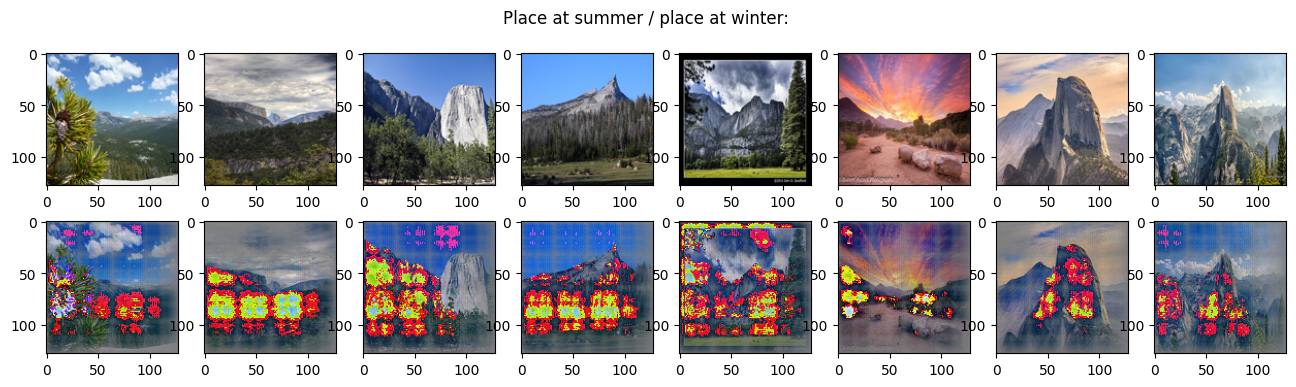

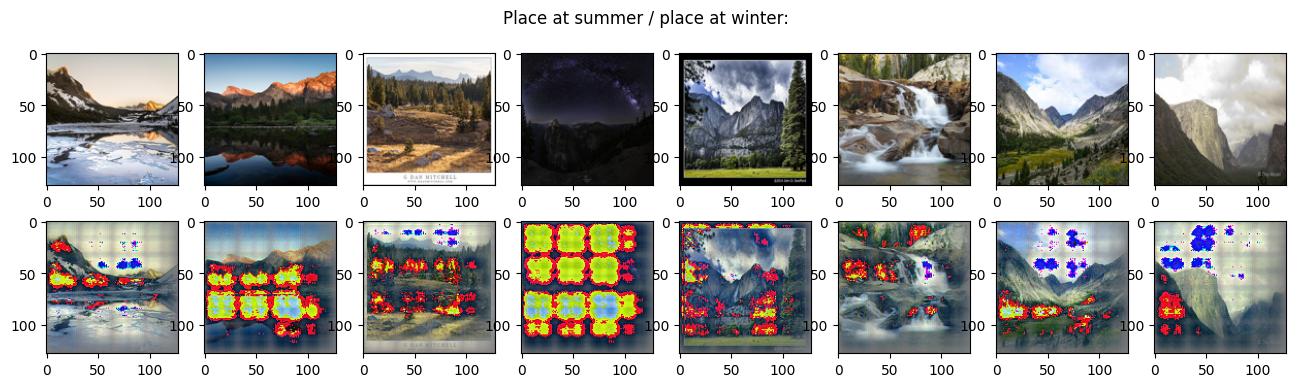

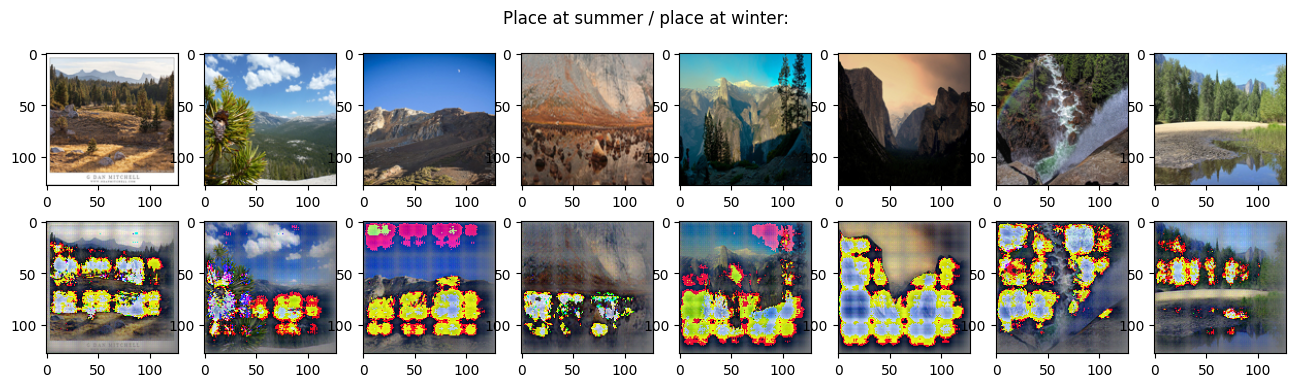

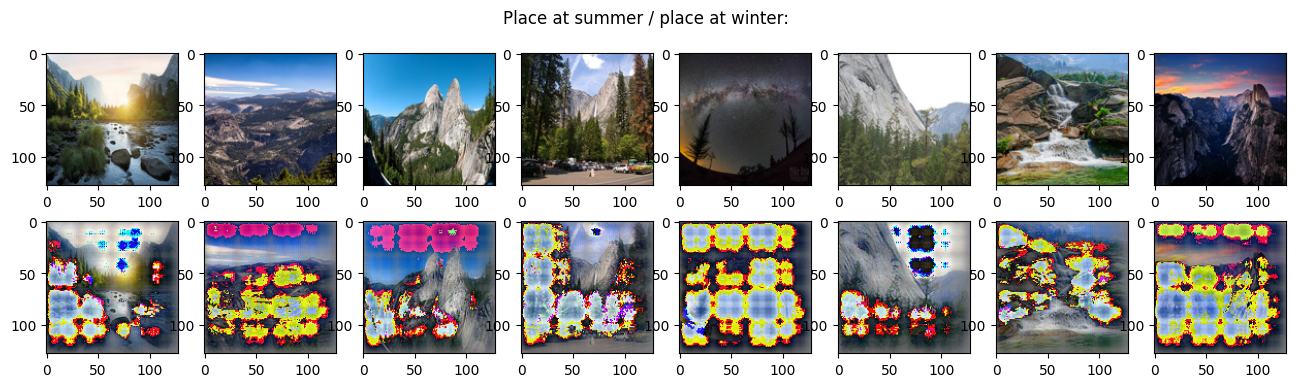

In [12]:
# Main training loop
epochs = 30
for epoch in range(epochs):
    d_iter = iter(dataloader)

    for i in tqdm(range(len(dataloader)), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        imgs = next(d_iter)[0]
        X = dataloader.dataset.take(imgs, A=True)
        Y = dataloader.dataset.take(imgs, A=False)
        #print(X.shape, Y.shape)
        # Training step
        losses = trainer.step(X.to(trainer.loss_c.theta_device()), Y.to(trainer.loss_c.omega_device()))

        loss_R = f"{losses['loss_R']:.4f}" if losses.get('loss_R') is not None else '?'
        print(f"\nEpoch {epoch}: " +
            f"Corr={losses['loss_corr']:.4f}, " +
            f"Cycle={losses['loss_cycle']:.4f}, " +
            f"Reg={loss_R}, " +
            f"Total={losses['loss_total']:.4f}")

    Val_iter = iter(dataVal)
    X_test = dataVal.dataset.take(next(Val_iter)[0], A=True).to(trainer.loss_c.theta_device())
    Y_generated = trainer.generate(X_test).detach().cpu()

    cols = 8

    # Visualize
    fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(16, 4))
    fig.suptitle('Place at summer / place at winter:')

    for i in range(cols):
        X_img = np.asarray(dataVal.dataset.to_image(X_test.cpu())[i], dtype=np.uint8)
        _ = axes[0][i].imshow(X_img)

        Y_img = np.asarray(dataVal.dataset.to_image(Y_generated.cpu())[i], dtype=np.uint8)
        _ = axes[1][i].imshow(Y_img)

    #plt.tight_layout()
    fig.show()

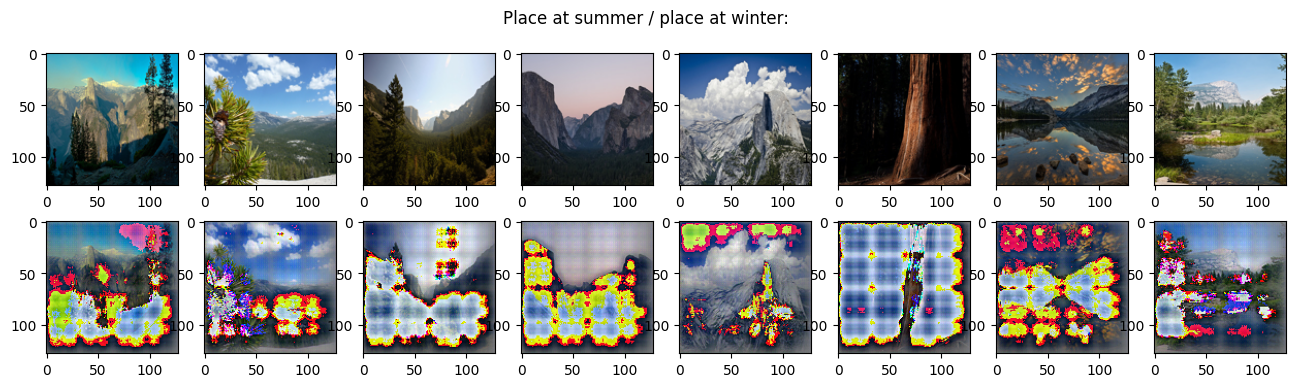

In [13]:
Val_iter = iter(dataVal)
X_test = dataVal.dataset.take(next(Val_iter)[0], A=True).to(trainer.loss_c.theta_device())
Y_generated = trainer.generate(X_test).detach().cpu()

cols = 8

# Visualize
fig, axes = plt.subplots(nrows=2, ncols=cols, figsize=(16, 4))
fig.suptitle('Place at summer / place at winter:')

for i in range(cols):
    X_img = np.asarray(dataVal.dataset.to_image(X_test.cpu())[i], dtype=np.uint8)
    _ = axes[0][i].imshow(X_img)

    Y_img = np.asarray(dataVal.dataset.to_image(Y_generated.cpu())[i], dtype=np.uint8)
    _ = axes[1][i].imshow(Y_img)

#plt.tight_layout()
fig.show()